## Leitura dos dados vindos da API do fogo cruzado

In [132]:
import json
import pandas as pd
import matplotlib.pyplot as plt

with open('../data/occurrences_2025-01-01_2025-05-31_city_8f3a026f-2fc4-419c-9918-f0684a2abbec_page_1.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data['data'])

### Ocorrências mês X ações policiais

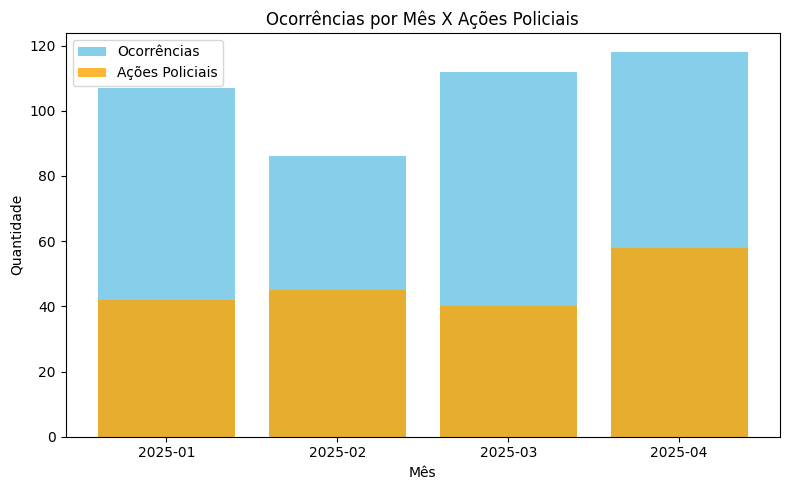

In [142]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df['month'] = df['date'].dt.to_period('M')

df_month_data = df.groupby(['month']).agg(
    count=('id', 'count'),
    min_date=('date', 'min'),
    max_date=('date', 'max'),
).reset_index()

df_month_data = df_month_data[df_month_data['month'] != pd.Period('2025-05', freq='M')]

ocorrencias_mes = df.groupby('month').agg(
  count=('id', 'count'),
  police_action=('policeAction', 'sum')
).reset_index()

ocorrencias_mes = ocorrencias_mes[ocorrencias_mes['month'] != pd.Period('2025-05', freq='M')]
porcentagem_policias = ocorrencias_mes['police_action'] / ocorrencias_mes['count'] * 100
plt.figure(figsize=(8, 5))
plt.bar(ocorrencias_mes['month'].astype(str), ocorrencias_mes['count'], label='Ocorrências', color='skyblue')
plt.bar(ocorrencias_mes['month'].astype(str), ocorrencias_mes['police_action'], label='Ações Policiais', color='orange', alpha=0.8)
plt.xlabel('Mês')
plt.ylabel('Quantidade')
plt.title('Ocorrências por Mês X Ações Policiais')
plt.legend()
plt.tight_layout()
plt.show()

Este gráfico nos permite visualizar a relação entre o número total de ocorrências (azul) e as ações policiais (amarelo) em cada mês. 
Podemos observar se existe uma correlação entre o aumento de ações policiais e a redução de ocorrências nos meses subsequentes, 
ou identificar meses críticos que exigem maior atenção das autoridades.
</br>
A porcentagem de ocorrências com ação policial em cada mês foi:
- Janeiro: 39,3%
- Fevereiro: 52,3%
- Março: 35,7%
- Abril: 49,2%

### Ocorrências com vítimas

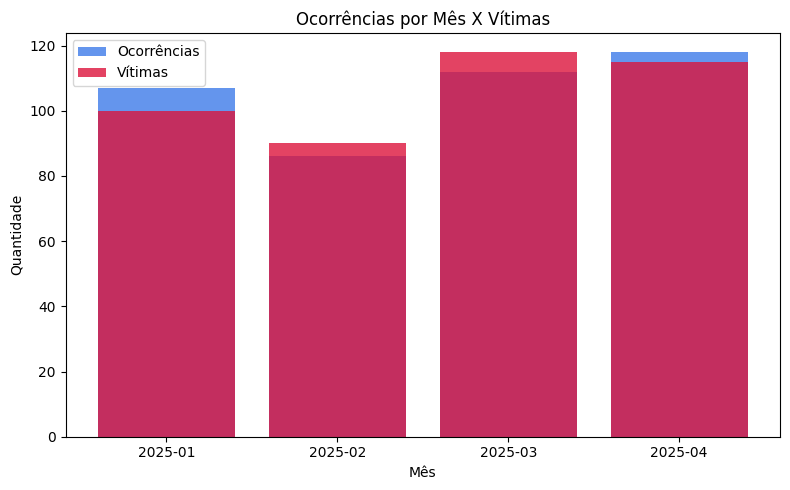

In [140]:
# Agrupa por mês e calcula o total de ocorrências e o total de vítimas (considerando o tamanho da lista 'victims')
df['num_vitimas'] = df['victims'].apply(lambda v: len(v) if isinstance(v, list) else 0)

ocorrencias_vitimas = df.groupby('month').agg(
  ocorrencias=('id', 'count'),
  vitimas=('num_vitimas', 'sum')
).reset_index()

ocorrencias_vitimas = ocorrencias_vitimas[ocorrencias_vitimas['month'] != pd.Period('2025-05', freq='M')]

plt.figure(figsize=(8, 5))
plt.bar(ocorrencias_vitimas['month'].astype(str), ocorrencias_vitimas['ocorrencias'], label='Ocorrências', color='cornflowerblue')
plt.bar(ocorrencias_vitimas['month'].astype(str), ocorrencias_vitimas['vitimas'], label='Vítimas', color='crimson', alpha=0.8)
plt.xlabel('Mês')
plt.ylabel('Quantidade')
plt.title('Ocorrências por Mês X Vítimas')
plt.legend()
plt.tight_layout()
plt.show()

Este gráfico compara o número total de ocorrências (azul) com o número de vítimas (rosa) por mês.
A visualização permite identificar se há uma disparidade entre a quantidade de eventos e o número de pessoas afetadas.

### Evolutivo diário das ocorrências

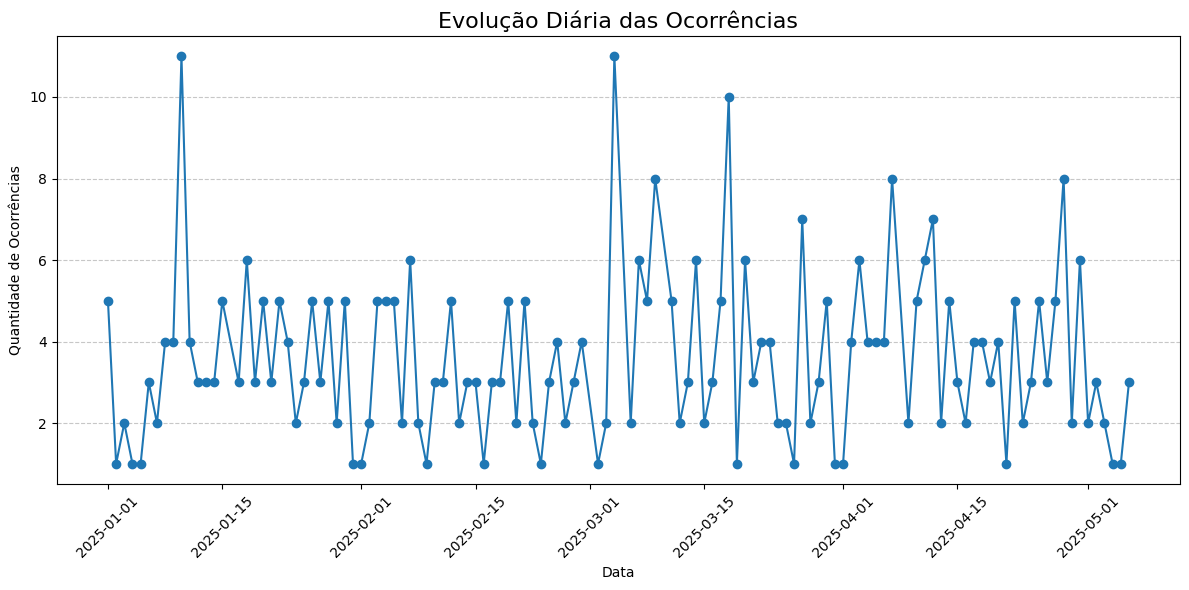

In [135]:
df['dia'] = df['date'].dt.date
ocorrencias_diarias = df.groupby('dia').size().reset_index(name='ocorrencias')

plt.figure(figsize=(12, 6))
plt.plot(ocorrencias_diarias['dia'], ocorrencias_diarias['ocorrencias'], marker='o', linestyle='-')
plt.title('Evolução Diária das Ocorrências', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Quantidade de Ocorrências')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

O gráfico apresenta a flutuação diária no número de ocorrências ao longo do período analisado.
Podemos identificar padrões temporais, como picos em determinados dias da semana ou períodos do mês,
além de tendências crescentes ou decrescentes no número de eventos. Esta análise mais granular
permite planejar ações preventivas com base em dias críticos ou períodos de maior incidência.

### Horário com maiores indíces de ocorrências

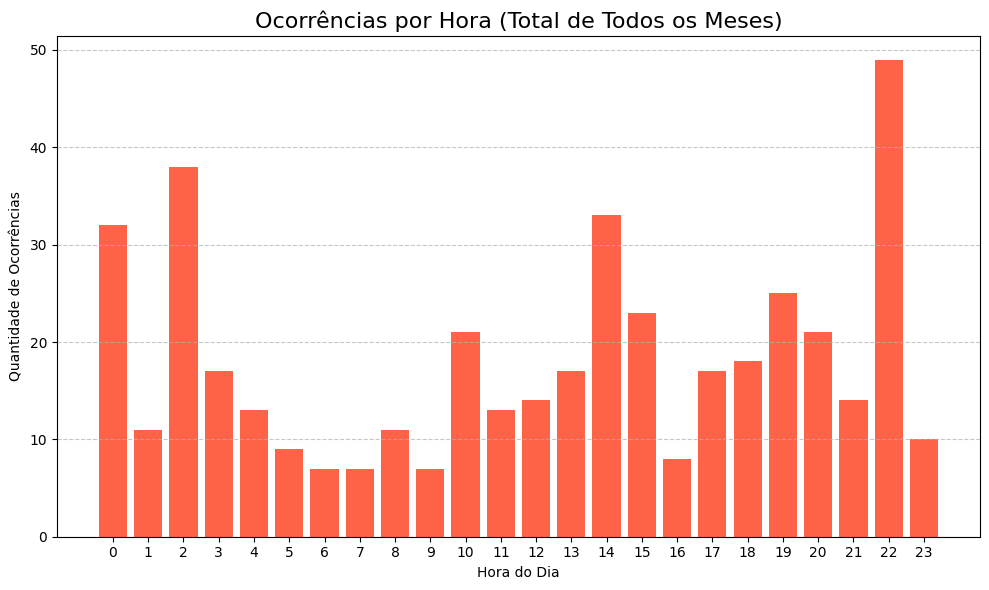

In [143]:
if 'hour' not in df.columns:
	df['hour'] = df['date'].dt.hour

hourly_total = df.groupby('hour').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.bar(hourly_total['hour'], hourly_total['count'], color='tomato')
plt.title('Ocorrências por Hora (Total de Todos os Meses)', fontsize=16)
plt.xlabel('Hora do Dia')
plt.ylabel('Quantidade de Ocorrências')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Os dados de ocorrências por horário mostram que os maiores picos acontecem principalmente no início da madrugada (0h, 2h) e no final da noite (22h).</br> Esses horários concentram o maior número de registros, indicando que eventos violentos tendem a ocorrer com mais frequência nesses períodos. Isso pode estar relacionado a fatores como menor circulação de pessoas nas ruas, atividades noturnas e menor presença policial visível. 

### Os 20 bairros com maiores indices de ocorrências

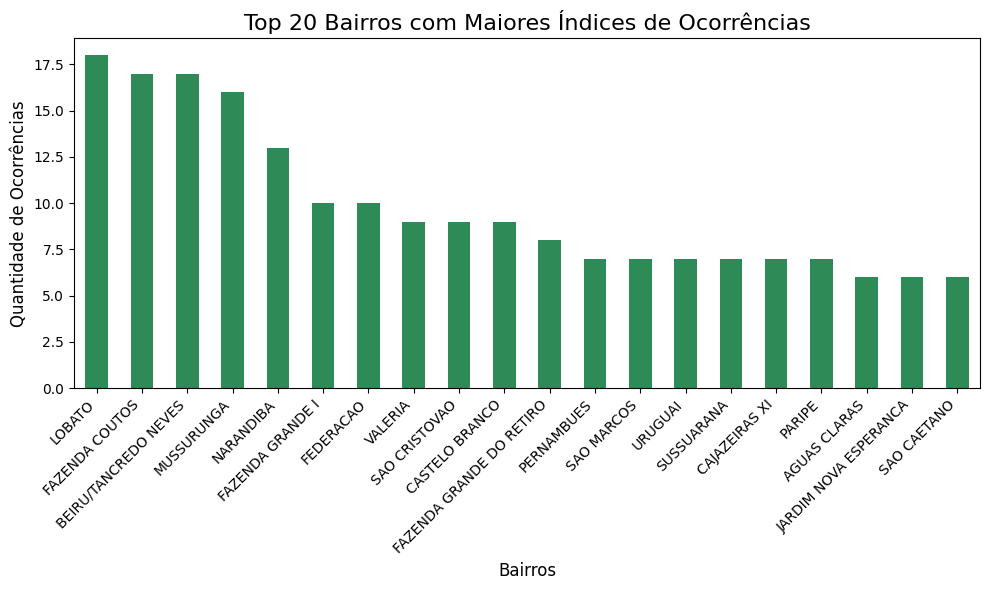

In [137]:
df['nome_bairro'] = df['neighborhood'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)

top_bairros = df['nome_bairro'].value_counts().head(20)

plt.figure(figsize=(10, 6))
ax = top_bairros.plot(kind='bar', color='seagreen')
plt.title('Top 20 Bairros com Maiores Índices de Ocorrências', fontsize=16)
plt.xlabel('Bairros', fontsize=12)
plt.ylabel('Quantidade de Ocorrências', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

O gráfico identifica os 20 bairros com maior concentração de ocorrências.
Esta análise geográfica é fundamental para direcionar recursos e ações específicas
para áreas mais vulneráveis. Bairros que aparecem no topo da lista podem necessitar
de programas especiais de segurança, aumento de efetivo policial ou intervenções
sociais para redução da violência.

### Localização das ocorrências no mapa

In [138]:
import folium

df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df_valid = df[df['latitude'].notnull() & df['longitude'].notnull()]

mapa = folium.Map(location=[df_valid['latitude'].mean(), df_valid['longitude'].mean()], zoom_start=12)

# Adiciona marcadores para cada ocorrência
for _, row in df_valid.iterrows():
    context = row['contextInfo']
    popup_content = f"<b>Motivo:</b> {context['mainReason']['name']}<br><b>Data:</b> {row['date']}"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.6,
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(mapa)

mapa

O mapa a localização geográfica precisa de cada ocorrência, permitindo
visualizar padrões de concentração espacial. Além de identificar hotspots de violência,
o mapa possibilita análises de proximidade com equipamentos públicos, fronteiras entre
comunidades ou áreas de disputa territorial. Cada ponto contém informações sobre o motivo
e a data da ocorrência, facilitando análises mais detalhadas.

### Principais motivos das ocorrências

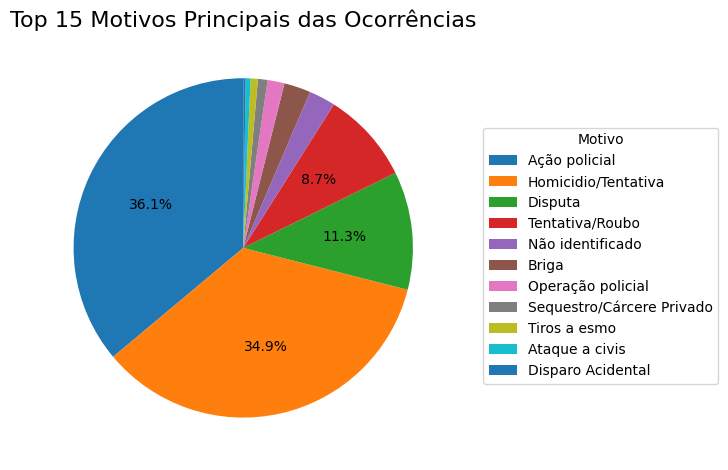

In [141]:
df['main_reason'] = df['contextInfo'].apply(lambda x: x.get('mainReason', {}).get('name') if isinstance(x, dict) else None)

main_reason_counts = df['main_reason'].value_counts().head(15)

def autopct_hide_small(pct):
  return ('%1.1f%%' % pct) if pct > 5 else ''

ax = main_reason_counts.plot(
  kind='pie',
  autopct=autopct_hide_small,
  startangle=90,
  legend=False,
  ylabel='',
  y=1.05 
)
plt.title('Top 15 Motivos Principais das Ocorrências', fontsize=16)
plt.tight_layout()
plt.legend(main_reason_counts.index, title="Motivo", bbox_to_anchor=(1.05, 0.8), loc='upper left')
plt.setp(ax.texts, size=10) 
for text in ax.texts:
  if "%" in text.get_text():
    text.set_text(text.get_text())  
  else:
    text.set_text("")  
plt.show()

A análise dos Top 15 Motivos Principais das Ocorrências mostra que "Ação policial" (157 casos) e "Homicidio/Tentativa" (152 casos) são os motivos mais frequentes,<br>
juntos representando a maior parte dos registros. Outros motivos relevantes incluem "Disputa" (49) e "Tentativa/Roubo" (38).<br>
Motivos como "Briga", "Operação policial" e "Sequestro/Cárcere Privado" aparecem em menor quantidade.<br>
Isso indica que a maioria das ocorrências está relacionada a ações policiais e crimes violentos, sugerindo foco em segurança pública e prevenção de homicídios.